In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bvh_converter import bvh_mod
from scipy.signal import savgol_filter

from matplotlib.lines import Line2D
from scipy.interpolate import interp1d

# from utils_trajectory.trajectory_by_subdiv import plot_foot_trajectories_by_subdiv
# from utils_trajectory.trajectory_by_beat import plot_foot_trajectories_by_beat
from utils_trajectory.trajectory_cycle import plot_all_cycles_trajectories
from utils_pipeline.pipeline_A import *

In [3]:
file_name = "BKO_E1_D1_02_Maraka"
motion_data_dir = "data/motion_data_pkl"

# Load the pickle file
mpkl_path = f"{motion_data_dir}/{file_name}_T.pkl"

with open(mpkl_path, 'rb') as f:
    motion_data = pickle.load(f)

motion_data["position"].keys()

dict_keys(['SEGMENT_PELVIS', 'SEGMENT_L5', 'SEGMENT_L3', 'SEGMENT_T12', 'SEGMENT_T8', 'SEGMENT_NECK', 'SEGMENT_HEAD', 'SEGMENT_RIGHT_SHOULDER', 'SEGMENT_RIGHT_UPPER_ARM', 'SEGMENT_RIGHT_FOREARM', 'SEGMENT_RIGHT_HAND', 'SEGMENT_LEFT_SHOULDER', 'SEGMENT_LEFT_UPPER_ARM', 'SEGMENT_LEFT_FOREARM', 'SEGMENT_LEFT_HAND', 'SEGMENT_RIGHT_UPPER_LEG', 'SEGMENT_RIGHT_LOWER_LEG', 'SEGMENT_RIGHT_FOOT', 'SEGMENT_RIGHT_TOE', 'SEGMENT_LEFT_UPPER_LEG', 'SEGMENT_LEFT_LOWER_LEG', 'SEGMENT_LEFT_FOOT', 'SEGMENT_LEFT_TOE'])

In [3]:
def plot_all_cycles_trajectories(
    file_name: str,
    mode: str,
    pelvis_zpos: np.ndarray,  # New parameter
    base_path_cycles: str = "data/virtual_cycles",
    base_path_logs: str = "data/logs_v2_may",
    frame_rate: float = 240,
    time_segments: list = None,  # List of (start, end) tuples
    n_beats_per_cycle: int = 4,
    n_subdiv_per_beat: int = 3,
    traj_threshold=0.15,
    figsize: tuple = (12, 12),  # Increased height for two plots
    dpi: int = 200,
    show_trajectories: bool = True,  # Control trajectory lines
    show_vlines: bool = True,        # Control vertical lines
    show_gray_plots: bool = True     # Control gray trajectory plots
):
    """
    Plot all foot trajectories in a single plot with grand average.
    Shows beat and subdivision lines with colors.
    X-axis shows 1.5 cycles (e.g., 0-6 for 4-beat cycles).
    Top subplot shows pelvis trajectories for included cycles.
    """

    # Use default window if no segments provided
    if time_segments is None:
        time_segments = [(0, 10)]

    # build file paths
    cycles_csv = os.path.join(base_path_cycles, f"{file_name}_C.csv")
    logs_onset_dir = os.path.join(base_path_logs, f"{file_name}_T", "onset_info")
    left_onsets_csv  = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_onsets.csv")
    right_onsets_csv = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_onsets.csv")
    left_zpos_csv    = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_zpos.csv")
    right_zpos_csv   = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_zpos.csv")

    # load data
    Lz = pd.read_csv(left_zpos_csv)["zpos"].values
    Rz = pd.read_csv(right_zpos_csv)["zpos"].values
    n_frames = len(Lz)
    times = np.arange(n_frames) / frame_rate

    # interpolation functions
    L_interp = interp1d(times, Lz, bounds_error=False, fill_value="extrapolate")
    R_interp = interp1d(times, Rz, bounds_error=False, fill_value="extrapolate")

    # Get overall time range for color mapping
    total_start = min(seg[0] for seg in time_segments)
    total_end = max(seg[1] for seg in time_segments)
    t_range = total_end - total_start

    # Get all onsets
    all_onsets = []
    for seg_start, seg_end in time_segments:
        cyc_df = pd.read_csv(cycles_csv)
        cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= seg_start) & (cyc_df["Virtual Onset"] <= seg_end)]
        if not cyc_df.empty:
            all_onsets.extend(cyc_df["Virtual Onset"].values[:-1])
    
    if not all_onsets:
        raise ValueError("No cycles found in any of the time segments")
    
    # Sort onsets
    all_onsets = np.sort(all_onsets)

    # Create figure with two subplots
    fig, (ax_pelvis, ax_feet) = plt.subplots(2, 1, figsize=figsize, dpi=dpi)
    cmap = plt.get_cmap('cool')

    # Define subdivision color mapping
    def get_subdiv_color(subdiv):
        total_subdiv = n_beats_per_cycle * n_subdiv_per_beat
        subdiv = ((subdiv - 1) % total_subdiv) + 1
        group = ((subdiv - 1) % 3) + 1
        if group == 1:
            return 'black'
        elif group == 2:
            return 'green'
        elif group == 3:
            return 'red'
        return 'gray'

    # Process each time segment
    all_L_trajectories = []
    all_R_trajectories = []
    all_times = []
    included_cycles = []  # New list to store cycle start times
    excluded_cycles = []    # New list to store cycle end times
    all_pelvis_trajectories = [] 
    
    for seg_start, seg_end in time_segments:
        # trim to window
        win_mask = (times >= seg_start) & (times <= seg_end)
        t_win = times[win_mask]
        L_win = Lz[win_mask]
        R_win = Rz[win_mask]
        pelvis_win = pelvis_zpos[win_mask]  # Get pelvis data for this window

        # cycles (downbeats)
        cyc_df = pd.read_csv(cycles_csv)
        cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= seg_start) & (cyc_df["Virtual Onset"] <= seg_end)]
        onsets = cyc_df["Virtual Onset"].values[:-1]

        # foot onsets
        left_df  = pd.read_csv(left_onsets_csv)
        right_df = pd.read_csv(right_onsets_csv)
        left_times  = left_df[(left_df["time_sec"]>=seg_start)&(left_df["time_sec"]<=seg_end)]["time_sec"].values
        right_times = right_df[(right_df["time_sec"]>=seg_start)&(right_df["time_sec"]<=seg_end)]["time_sec"].values

        # Plot trajectories for each cycle
        for i, c in enumerate(onsets):
            # Get cycle start and end from actual onsets
            cycle_start = c
            cycle_end = onsets[i + 1] if i < len(onsets) - 1 else c + (onsets[1] - onsets[0])  # fallback to first cycle duration
            cycle_duration = cycle_end - cycle_start
            beat_len = cycle_duration / n_beats_per_cycle
            
            m = (t_win >= cycle_start) & (t_win <= cycle_end)
            tr = (t_win[m] - cycle_start) / beat_len  # normalize to 0-4 beats

            if show_trajectories:
                col = cmap((c-total_start)/t_range)
                has_any_onsets = any(cycle_start <= t <= cycle_end for t in left_times) or any(cycle_start <= t <= cycle_end for t in right_times)
                
                # Plot gray trajectories only for cycles without any onsets
                if show_gray_plots and not has_any_onsets:
                    ax_feet.plot(tr, L_win[m], '-', color='gray', alpha=0.9)
                    ax_feet.plot(tr, R_win[m], '--', color='gray', alpha=0.9)
                    # Also plot shifted for 1.5 cycles
                    ax_feet.plot(tr + 4, L_win[m], '-', color='gray', alpha=0.9)
                    ax_feet.plot(tr + 4, R_win[m], '--', color='gray', alpha=0.9)
                
                # Plot colored trajectories for cycles with any onsets
                if has_any_onsets:
                    ax_feet.plot(tr, L_win[m], '-', color=col, alpha=0.3, label="Left Foot" if c==onsets[0] else "")
                    ax_feet.plot(tr, R_win[m], '--', color=col, alpha=0.3, label="Right Foot" if c==onsets[0] else "")
                    # Also plot shifted for 1.5 cycles
                    ax_feet.plot(tr + 4, L_win[m], '-', color=col, alpha=0.3)
                    ax_feet.plot(tr + 4, R_win[m], '--', color=col, alpha=0.3)
                
                # Apply thresholding when storing trajectories for averaging
                traj_max = max(np.nanmax(L_win[m]), np.nanmax(R_win[m]))
                if traj_max >= traj_threshold:
                    all_L_trajectories.append(L_win[m])
                    all_R_trajectories.append(R_win[m])
                    all_pelvis_trajectories.append(pelvis_win[m])  # Add pelvis trajectory
                    all_times.append(tr)
                    # Store the cycle timing information for included trajectories
                    included_cycles.append((cycle_start, cycle_end))
                    # Plot pelvis trajectory for included cycles
                    ax_pelvis.plot(tr, pelvis_win[m], '-', color=col, alpha=0.3)
                    ax_pelvis.plot(tr + 4, pelvis_win[m], '-', color=col, alpha=0.3)
                else:
                    excluded_cycles.append((cycle_start, cycle_end))

                # Plot markers for foot onsets
                for lt in left_times:
                    if cycle_start <= lt <= cycle_end:
                        rel = (lt - cycle_start) / beat_len
                        if show_vlines:
                            ax_feet.axvline(rel, color=col, linestyle='-', alpha=0.5)
                        ax_feet.plot(rel, L_interp(lt), 'o', ms=8, markeredgecolor='k', 
                                markerfacecolor='blue', alpha=0.8)
                        # Also plot shifted for 1.5 cycles
                        if show_vlines:
                            ax_feet.axvline(rel + 4, color=col, linestyle='-', alpha=0.5)
                        ax_feet.plot(rel + 4, L_interp(lt), 'o', ms=8, markeredgecolor='k', 
                                markerfacecolor='blue', alpha=0.8)

                for rt in right_times:
                    if cycle_start <= rt <= cycle_end:
                        rel = (rt - cycle_start) / beat_len
                        if show_vlines:
                            ax_feet.axvline(rel, color=col, linestyle='--', alpha=0.5)
                        ax_feet.plot(rel, R_interp(rt), 'x', ms=8, markeredgecolor='red', 
                                color='red', alpha=0.8)
                        # Also plot shifted for 1.5 cycles
                        if show_vlines:
                            ax_feet.axvline(rel + 4, color=col, linestyle='--', alpha=0.5)
                        ax_feet.plot(rel + 4, R_interp(rt), 'x', ms=8, markeredgecolor='red', 
                                color='red', alpha=0.8)
    
    print("count of included trajectories: ", len(included_cycles))
    print("count of excluded trajectories: ", len(excluded_cycles))
    print(included_cycles)
    
    pickle_dir = "traj_files"
    # Save the dictionaries
    with open(os.path.join(pickle_dir, f'{file_name}_included_{traj_threshold}.pkl'), 'wb') as f:
        pickle.dump(included_cycles, f)
    
    with open(os.path.join(pickle_dir, f'{file_name}_excluded_{traj_threshold}.pkl'), 'wb') as f:
        pickle.dump(excluded_cycles, f)
    
    # Calculate and plot grand average for feet
    if all_L_trajectories and all_R_trajectories and all_pelvis_trajectories:
        # Interpolate all trajectories to the same time points
        common_times = np.linspace(0, n_beats_per_cycle, 100)
        L_avg = np.zeros(len(common_times))
        R_avg = np.zeros(len(common_times))
        pelvis_avg = np.zeros(len(common_times))  # New array for pelvis average
        count = 0
        
        for L_traj, R_traj, P_traj, t_traj in zip(all_L_trajectories, all_R_trajectories, all_pelvis_trajectories, all_times):
            L_interp = interp1d(t_traj, L_traj, bounds_error=False, fill_value="extrapolate")
            R_interp = interp1d(t_traj, R_traj, bounds_error=False, fill_value="extrapolate")
            P_interp = interp1d(t_traj, P_traj, bounds_error=False, fill_value="extrapolate")  # New interpolation
            L_avg += L_interp(common_times)
            R_avg += R_interp(common_times)
            pelvis_avg += P_interp(common_times)  # Add to pelvis average
            count += 1
        
        if count > 0:
            L_avg /= count
            R_avg /= count
            pelvis_avg /= count  # Normalize pelvis average
            
            # Plot foot averages
            ax_feet.plot(common_times, L_avg, '-', color='blue', linewidth=3, label='Left Foot Average')
            ax_feet.plot(common_times, R_avg, '--', color='red', linewidth=3, label='Right Foot Average')
            ax_feet.plot(common_times + 4, L_avg, '-', color='blue', linewidth=3)
            ax_feet.plot(common_times + 4, R_avg, '--', color='red', linewidth=3)
            
            # Plot pelvis average
            ax_pelvis.plot(common_times, pelvis_avg, '-', color='purple', linewidth=3, label='Pelvis Average')
            ax_pelvis.plot(common_times + 4, pelvis_avg, '-', color='purple', linewidth=3)

    # Add vertical lines and grid for both subplots
    for ax in [ax_pelvis, ax_feet]:
        # Add vertical line at position 0 (will display as 1)
        ax.axvline(0, color='black', linewidth=2, alpha=0.8)
        ax.axvline(4, color='black', linewidth=2, alpha=0.8)  # Start of second cycle

        # Add beat and subdivision lines for 1.5 cycles
        for cycle in range(2):  # 0 and 1
            for beat in range(1, n_beats_per_cycle + 1):
                pos = cycle * n_beats_per_cycle + beat
                ax.axvline(pos, color='black', linewidth=2, alpha=0.8)
                # Add subdivision lines
                for subdiv in range(1, n_subdiv_per_beat):
                    subdiv_pos = cycle * n_beats_per_cycle + (beat - 1) + subdiv / n_subdiv_per_beat
                    subdiv_num = (beat - 1) * n_subdiv_per_beat + subdiv + 1
                    grid_color = get_subdiv_color(subdiv_num)
                    ax.axvline(subdiv_pos, color=grid_color, alpha=0.8, linewidth=1.5)

        # Set x-axis for 1.5 cycles
        xticks = [0.0, 0.33, 0.67, 1.0, 1.33, 1.67, 2.0, 2.33, 2.67, 3.0, 3.33, 3.67, 4.0, 4.33, 4.67, 5.0, 5.33, 5.67, 6.0]
        xticklabels = ['1.00', '1.33', '1.67', '2.00', '2.33', '2.67', '3.00', '3.33', '3.67', '4.00', '4.33', '4.67', '5.00', '5.33', '5.67', '6.00', '6.33', '6.67', '7.00']
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)  # Label as 1-based
        ax.set_xlim(0.0, 6.0)
        ax.grid(True, alpha=0.3)

    # Set labels and titles
    ax_pelvis.set_ylabel("Pelvis Y Position")
    ax_feet.set_ylabel("Foot Y Position")
    ax_feet.set_xlabel("Cycle Span")
    
    # Set titles
    ax_pelvis.set_title("Pelvis Trajectories")
    ax_feet.set_title(f"Foot Trajectories with Grand Average | {mode} | Threshold: {traj_threshold}")
    
    # Add all legends together outside the plot
    custom = [
        Line2D([0],[0],marker='o', color='w', markerfacecolor='blue', ms=8, markeredgecolor='k'),
        Line2D([0],[0],marker='x', color='red', ms=8),
        Line2D([0],[0],color='blue', lw=3),
        Line2D([0],[0],color='red', lw=3, linestyle='--'),
        Line2D([0],[0],color='purple', lw=3),  # Add pelvis average to legend
        Line2D([0],[0],color='gray', lw=1.5),
        Line2D([0],[0],color='black', lw=1.5),
        Line2D([0],[0],color='green', lw=1.5),
        Line2D([0],[0],color='red', lw=1.5)
    ]
    labels = [
        "Left Onset", 
        "Right Onset", 
        "Left Foot Average", 
        "Right Foot Average", 
        "Pelvis Average",  # Add pelvis average label
        "Undetected trajectory",
        "Subdivision 1 (1,4,7,10)", 
        "Subdivision 2 (2,5,8,11)", 
        "Subdivision 3 (3,6,9,12)"
    ]
    # fig.legend(custom, labels, loc='center right', bbox_to_anchor=(1.15, 0.5), framealpha=0.3)

    # # Add colorbar
    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(total_start, total_end))
    # sm.set_array([])
    # plt.colorbar(sm, ax=[ax_pelvis, ax_feet], label='Time in recording (s)')

    # plt.tight_layout()
    # return fig, (ax_pelvis, ax_feet)

    # Create a new axes for the legend
    legend_ax = fig.add_axes([1.02, 0.1, 0.1, 0.8])
    legend_ax.axis('off')
    legend_ax.legend(custom, labels, loc='center left', framealpha=0.3)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(total_start, total_end))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
    plt.colorbar(sm, cax=cbar_ax, label='Time in recording (s)')

    # Adjust layout to make room for legend and colorbar
    fig.subplots_adjust(right=0.85)
    
    return fig, (ax_pelvis, ax_feet)

### Visualize trajectories with thresholding and average

count of included trajectories:  25
count of excluded trajectories:  26
[(166.55722222199998, 168.02211111066666), (168.02211111066666, 169.503), (169.503, 170.9785555553333), (170.9785555553333, 172.4505555553333), (172.4505555553333, 173.9083333333333), (173.9083333333333, 175.364333333), (175.364333333, 176.802555555), (176.802555555, 178.222111111), (198.59099999966668, 199.94477777766667), (199.94477777766667, 201.261222222), (201.261222222, 202.5661111106667), (202.5661111106667, 203.87188888866663), (313.0941111106667, 314.43188888866666), (314.43188888866666, 315.782111111), (315.782111111, 317.10211111066667), (317.10211111066667, 318.43011111100003), (319.7589999996667, 321.0807777776667), (321.0807777776667, 322.4025555553333), (325.068333333, 326.38033333333334), (328.99099999966666, 330.274555555), (330.274555555, 331.5225555553333), (331.5225555553333, 332.758111111), (332.758111111, 333.9989999996667), (333.9989999996667, 335.2452222223333), (335.2452222223333, 336.53944

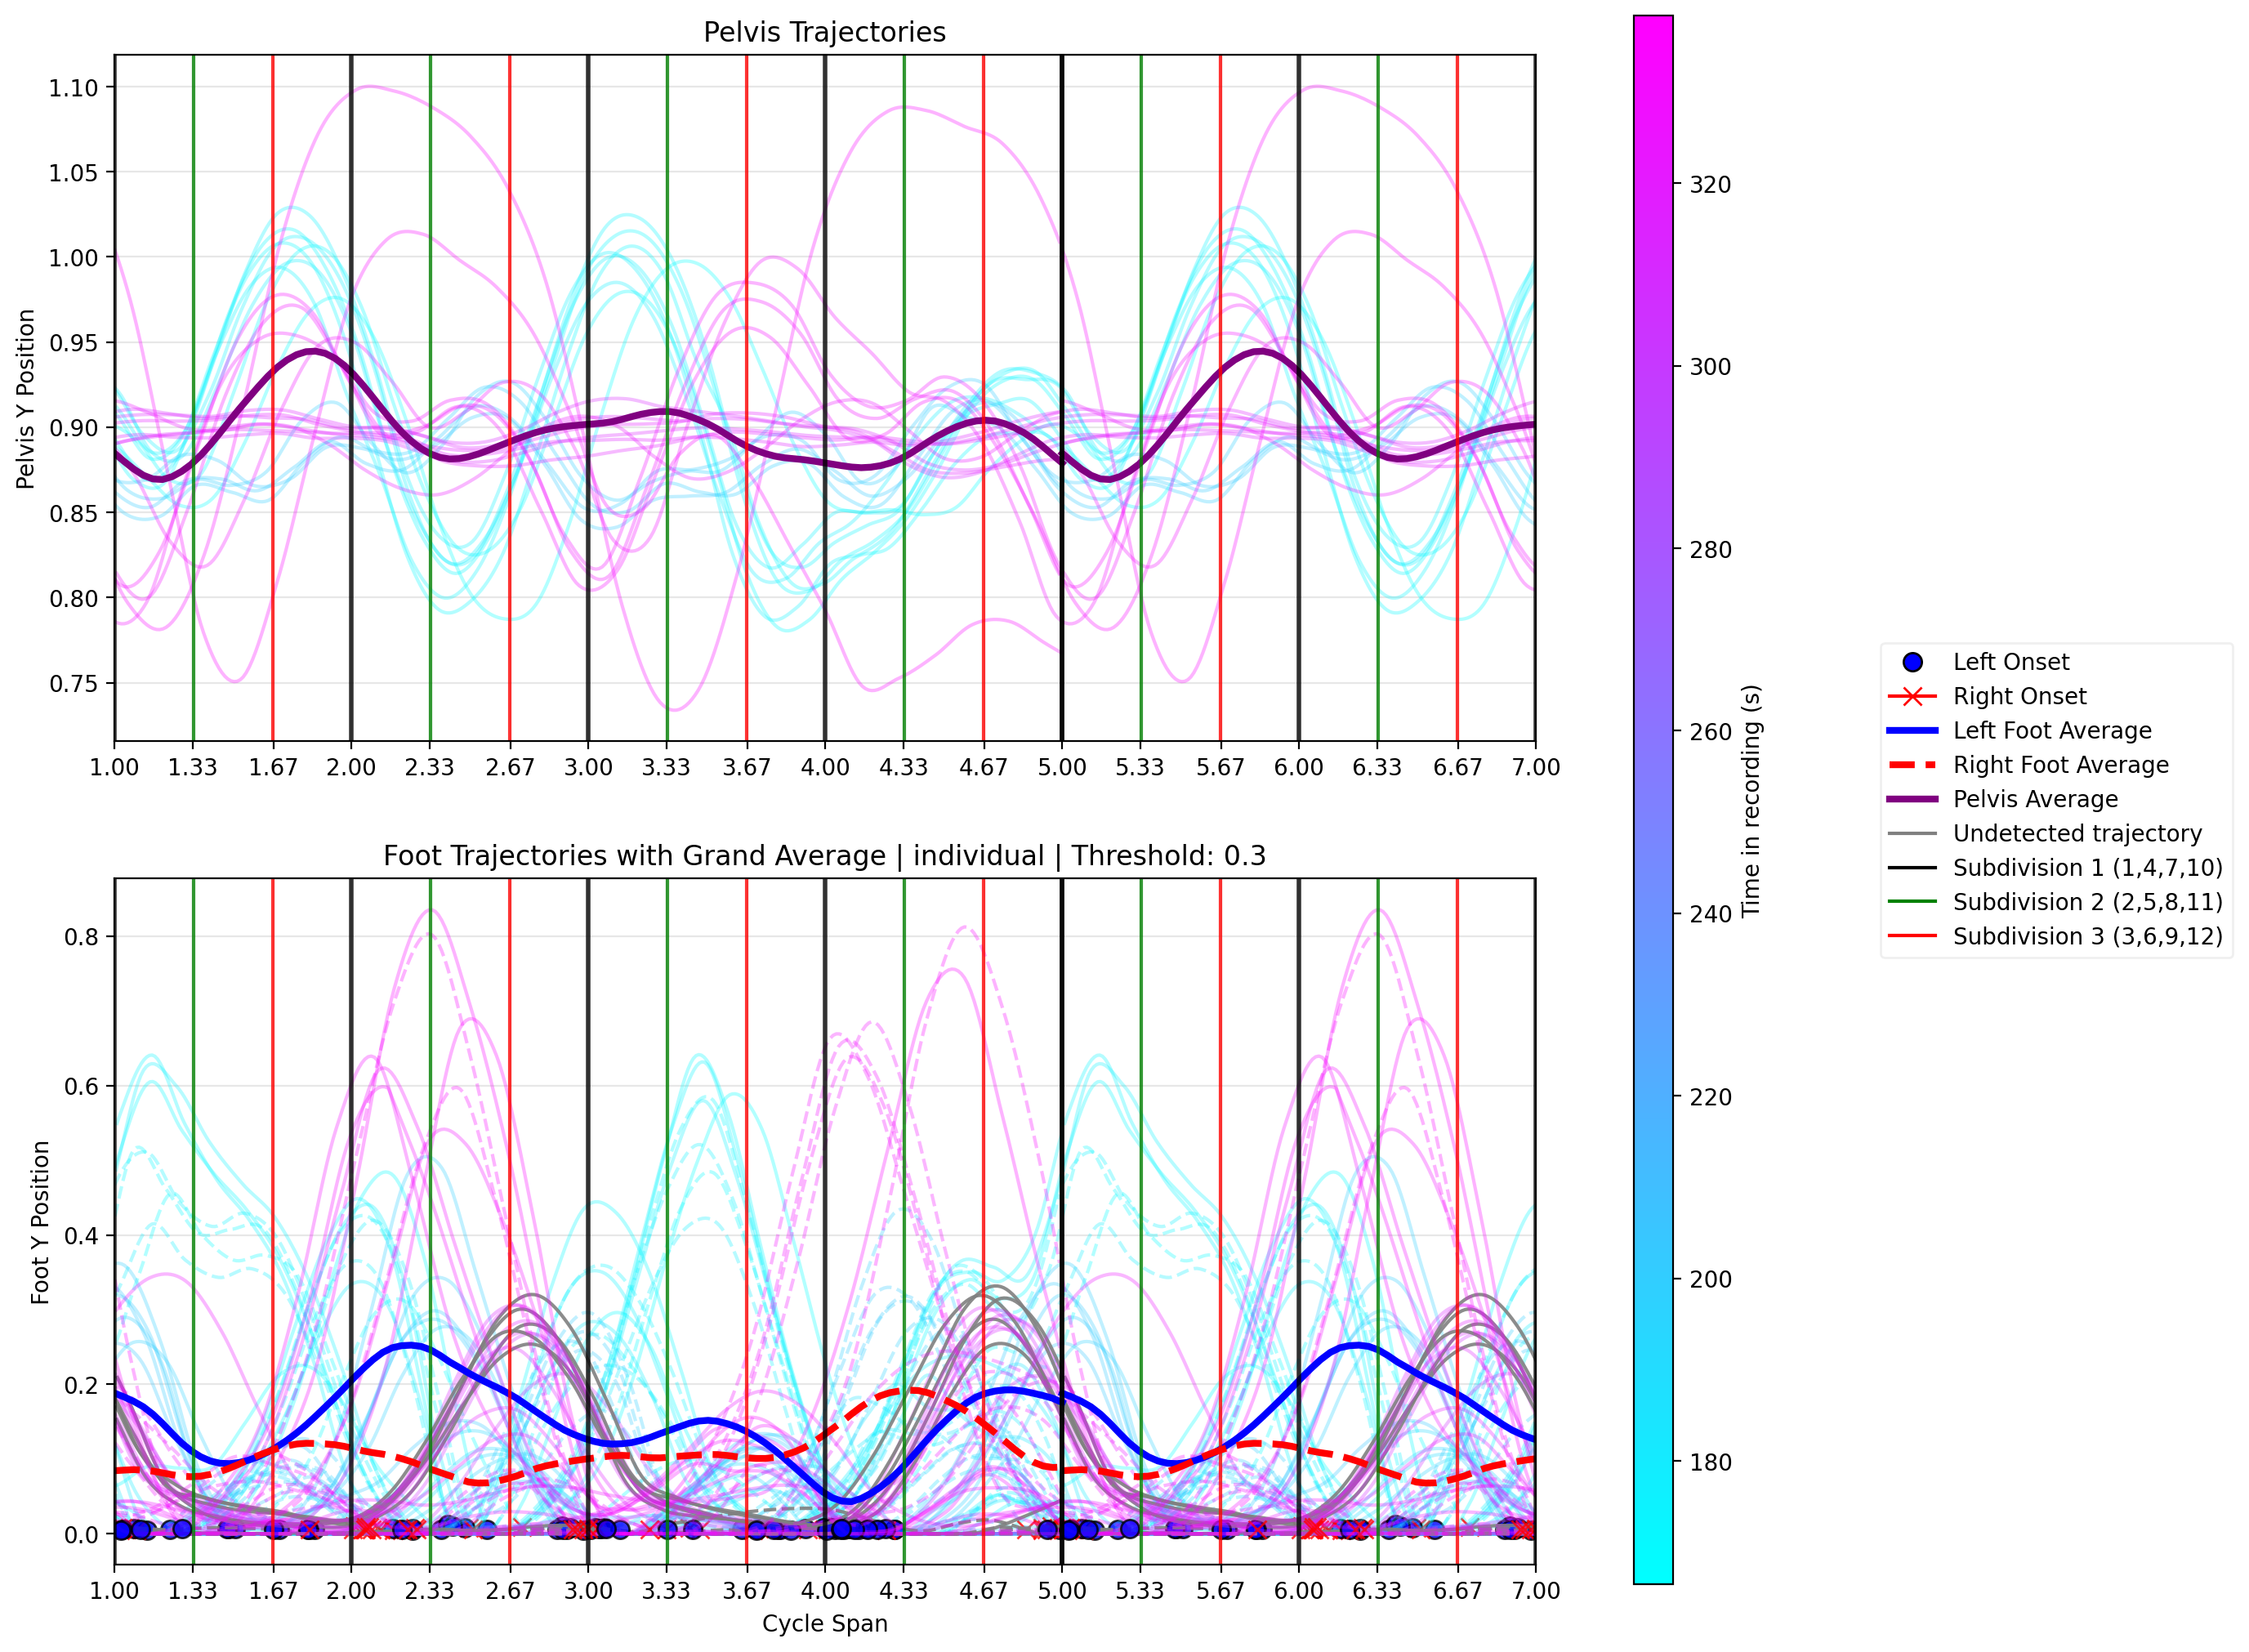

In [6]:
file_name = "BKO_E1_D1_02_Maraka"
mode_df = pd.read_csv("data/subset_dance_annotation/" + file_name + "_Dancers.csv")

# file_name = "BKO_E1_D1_02_Maraka_T"     # pickle file 
motion_data_dir = "data/motion_data_pkl"

# Load the pickle file
mpkl_path = f"{motion_data_dir}/{file_name}_T.pkl"

with open(mpkl_path, 'rb') as f:
    motion_data = pickle.load(f)

pelvis_zpos = motion_data["position"]['SEGMENT_PELVIS'][:,2]

mode_group = mode_df[mode_df["mocap"] == "gr"].reset_index(drop=True)
mode_individual = mode_df[mode_df["mocap"] == "in"].reset_index(drop=True)
mode_audience = mode_df[mode_df["mocap"] == "au"].reset_index(drop=True)

# dict of segments
segments = {
    "group":      get_segments(mode_group,      "gr"),
    "individual": get_segments(mode_individual, "in"),
    "audience":   get_segments(mode_audience,   "au")
}


# mode_name, segmnt = get_tsegment_for("group", mode_group,      "gr")
mode_name, segmnt = get_tsegment_for("individual", mode_individual, "in")
# mode_name, segmnt   = get_tsegment_for("audience",   mode_audience,   "au")


# save_dir = f"output_static_plot/all_cycles_trajectories/{file_name}"
# os.makedirs(save_dir, exist_ok=True)

fig, ax = plot_all_cycles_trajectories(
            file_name=file_name,
            mode=mode_name,
            pelvis_zpos = pelvis_zpos,
            base_path_cycles="data/virtual_cycles",
            base_path_logs="data/logs_v2_may",
            time_segments=segmnt,  # Pass all time segments for this mode
            n_beats_per_cycle=4, 
            n_subdiv_per_beat=3, 
            traj_threshold=0.3,     # exclude trajectories below this threshold
            show_gray_plots= True,
            show_trajectories= True,  # New parameter to control trajectory lines
            show_vlines= False        # New parameter to control vertical lines
        )

plt.show(fig)

# fig.savefig(os.path.join(save_dir, f"{file_name}_{mode}.png"))
# plt.close(fig)